# Семинар №5

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# вспомогательная функция
def plot_one_image(src_image, is_gray=False):
    """
    Отрисовать с помощью plt исходное изображение.
    
    :param src_image: np.ndarray: исходное изображение
    :param is_gray: bool: флаг для отображения ЧБ изображений
    :return: None
    """
    fig, m_axs = plt.subplots(1, 1, figsize=(6.4*2, 4.8*2), constrained_layout=False)
    ax1 = m_axs

    cmap = 'gray' if is_gray else None
    ax1.set_title('Исходное изображение')
    ax1.imshow(src_image, cmap=cmap)
    ax1.set_xticks([]), ax1.set_yticks([])
    plt.show()

# Особые точки

Настало время перейти к более продвинутым методам сравнения изображений. На прошлых занятих мы рассматривали методы, которые базировались больше на глобальных признаках изображения. Однако, для того, чтобы исследовать схожесть неких изображений, недостаточно иметь представление только глобальных признаков. В качестве шага в определение локальных признаков мы рассматривали метод "плавающего окна". 

Итак, введем предположение, что на изображении можно найти локальные признаки в некой окрестности __ключевой точки__. Вопрос: что брать за ключевую точку и какую окрестность?

Для начала разберемся почему глобальные признаки иногда работают плохо на примере следующих изображений.

<img src="https://i.ibb.co/6FFHWd5/image--000.jpg" alt="Drawing" style="width: 600px;"/> 

Из всего этого вытекает идея - хочется как-то выделить точки их окрестности, к которым можно привязаться для сравнения. 

## Сравнение изображений при помощи локальных признаков: основные шаги

1. Локализация особых точек


2. Выделение особых фрагментов – окрестности ключевых точек, инвариантные к различного рода преобразованиям


3. Построение векторов признаков для найденных фрагментов


4. Сопоставление наборов локальных признаков для двух изображений
    
<img src="https://i.ibb.co/fD6fRDJ/image--007.jpg" alt="Drawing" style="width: 400px;"/> 

# Harris Corner Detection

Одна из ранних попыток найти эти углы была сделана Крисом Харрисом и Майком Стивенсом в их статье «Комбинированный детектор углов и краев» в 1988 году, так что теперь она называется «Детектор углов Харриса». Он перенес эту простую идею в математическую форму. Это в основном находит разницу в интенсивности для смещения (u, v) во всех направлениях. Это выражается в следующей форме:

$$E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$$

Оконная функция $w(x,y)$ - это либо прямоугольное окно, либо гауссово окно, которое дает вес пикселям внизу.

Мы должны максимизировать функцию $E(u, v)$ для обнаружения углов. На лекции был показан переход к матричной записи:

$$E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}$$

где

$$M = \sum_{x,y} w(x,y) \begin{bmatrix}I_x I_x & I_x I_y \\
                                     I_x I_y & I_y I_y \end{bmatrix}$$

Здесь $I_x$ и $I_y$ являются производными изображения в направлениях $x$ и $y$ соответственно.

Затем идет основная часть. После этого они создали счет, в основном уравнение, которое определит, может ли окно содержать угол или нет.

$$R = det(M) - k(trace(M))^2$$

где

1. $det (M) = \lambda_1 \lambda_2$

2. $trace (M) = \lambda_1 + \lambda_2$

3. $\lambda_1$ и $\lambda_2$ - собственные значения $M$

Таким образом, значения этих собственных значений определяют, является ли область угловой, кромочной или плоской.

1. Когда $|R|$ маленький, что случается, когда $\lambda_1$ и $\lambda_2$ маленькие, область плоская.

2. Когда $R<0$, что происходит, когда $\lambda_1 >> \lambda_2$ или наоборот, область является ребром.

3. Когда $R$ большое, что происходит, когда $\lambda_1$ и $\lambda_2$ большие и $\lambda_1 \sim \lambda_2$, регион является углом.

На картинке это можно представить следующим образом:
<img src="https://i.ibb.co/3CvVLTP/image--017.jpg" alt="Drawing" style="width: 600px;"/> 

## Harris Corner Detector in OpenCV
Для этой цели в OpenCV есть функция ```cv2.cornerHarris(img, blockSize, ksize, k)```. Его аргументы:

1. **img** - входное изображение, оно должно быть в градациях серого и иметь тип float32.
2. **blockSize** - это размер окрестности, рассматриваемый для обнаружения угла
3. **ksize** - параметр апертуры используемого производного Собеля.
4. **k** - свободный параметр детектора Харриса в уравнении.

Результат функции:
$dst(x,y)=detM(x,y)−k⋅(trM(x,y))2$

In [3]:
fname = 'img/lk.jpg'
image = cv2.imread(fname)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

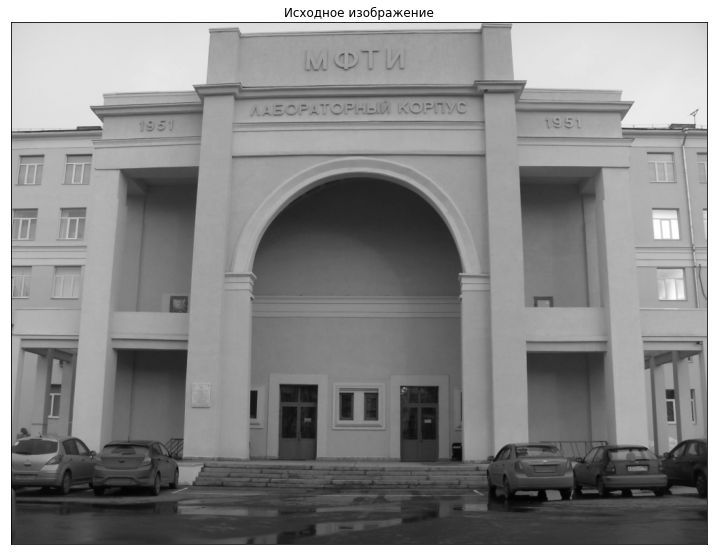

In [4]:
plot_one_image(gray, is_gray=True)

In [12]:
dst = cv2.cornerHarris(gray, blockSize=3, ksize=1, k=0.14)
dst = cv2.dilate(dst, None)  # расширение

print(f'Размер изображения: {image.shape}, \nразмер результата dst: {dst.shape}')

Размер изображения: (768, 1024, 3), 
размер результата dst: (768, 1024)


In [13]:
dst.shape

(768, 1024)

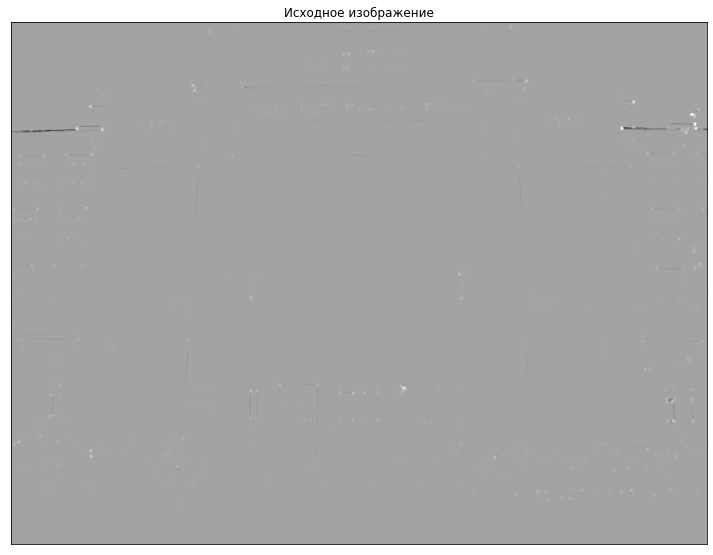

In [14]:
plot_one_image(dst, is_gray=True)

In [15]:
# нормировка значений
dst_normed = (dst - dst.min()) / (dst.max() - dst.min())

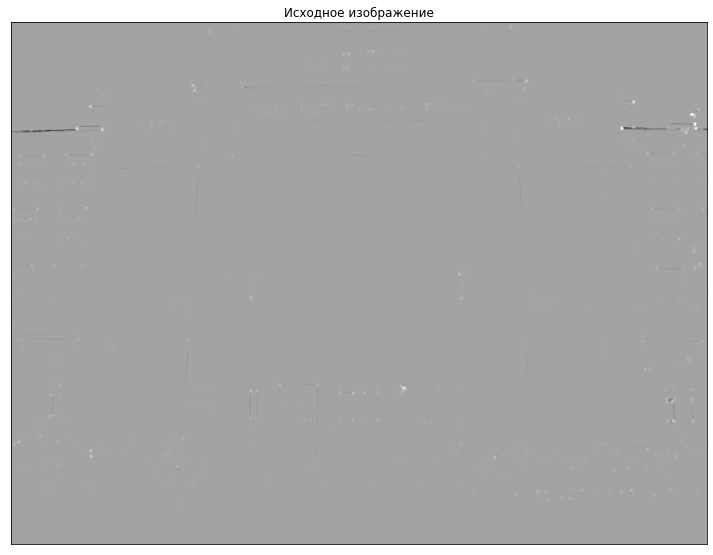

In [16]:
# Карта углов
plot_one_image(dst_normed, is_gray=True)

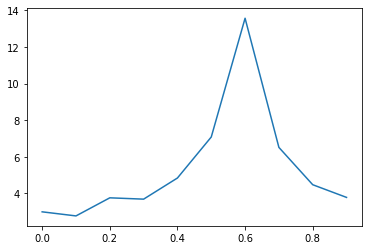

In [17]:
hist, bins = np.histogram(dst_normed.flatten(), 10, [0., 1.0])

plt.plot(bins[:-1], np.log(hist))
plt.show()

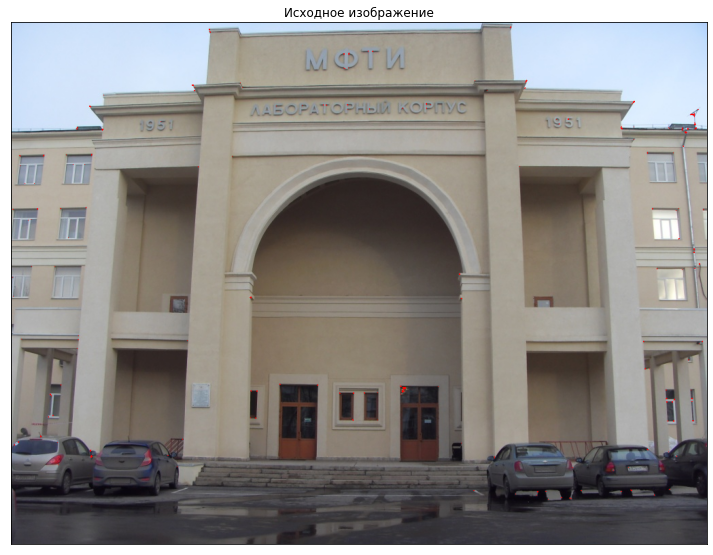

In [11]:
# Порог для оптимального значения, он может варьироваться в зависимости от изображения
draw_image = image.copy()
draw_image[dst_normed > 0.8] = [255, 0, 0]

plot_one_image(draw_image)

Рассмотрим [```cv2.cornerEigenValsAndVecs```](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga3dbce297c1feb859ee36707e1003e0a8)

Рассчитывает минимальное собственное значение градиентных матриц для определения угла.

Функция аналогична функции ```cv2.cornerHarris```, но вычисляет и сохраняет только собственное минимальное значение ковариационной матрицы производных, т.е. min(λ1,λ2) в терминах формул в описании [cornerEigenValsAndVecs](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga4055896d9ef77dd3cacf2c5f60e13f1c).

In [18]:
dst = cv2.cornerEigenValsAndVecs(gray, blockSize=3, ksize=1)

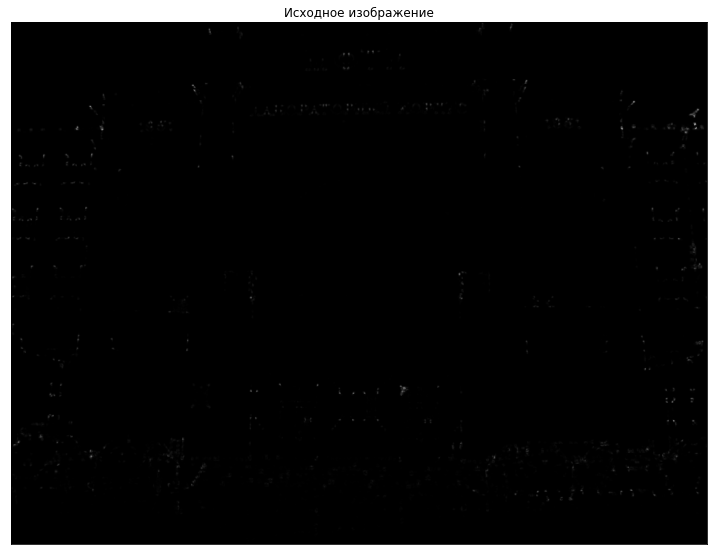

In [19]:
dst = cv2.cornerMinEigenVal(gray, 3, 0.1)
dst_normed = (dst - dst.min()) / (dst.max() - dst.min())
plot_one_image(dst_normed, is_gray=True)

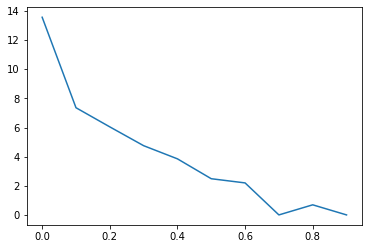

In [20]:
hist, bins = np.histogram(dst_normed.flatten(), 10, [0., 1.0])

plt.plot(bins[:-1], np.log(hist))
plt.show()

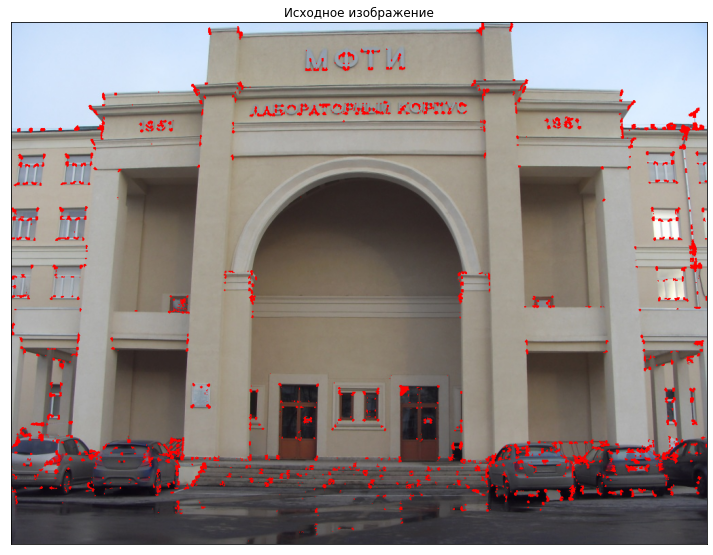

In [21]:
# Threshold for an optimal value, it may vary depending on the image.
draw_image = image.copy()
draw_image[dst_normed > 0.01] = [255, 0, 0]

plot_one_image(draw_image)

# Shi-Tomasi Corner Detector & Good Features to Track
В прошлой главе мы увидели детектор углов Харриса. Позже в 1994 году Дж. Ши и К. Томази внесли небольшую модификацию в свою статью Good Features to Track, которая показывает лучшие результаты по сравнению с детектором Harris Corner Detector. Оценочную функцию в Harris Corner Detector предоставили:

$$R = \lambda_1 \lambda_2 - k(\lambda_1+\lambda_2)^2$$

Вместо этого Ши-Томаси предложил:

$$R = min(\lambda_1, \lambda_2)$$

Если оно больше порогового значения, оно рассматривается как угол. Если мы построим его в пространстве $\lambda_1 - \lambda_2$, как мы это делали в Harris Corner Detector, мы получим изображение, как показано ниже:

<img src="https://i.ibb.co/sCBQZVp/shitomasi_space.png" alt="Drawing" style="width: 400px;"/> 


Из рисунка видно, что только когда $\lambda_1$ и $\lambda_2$ превышают минимальное значение $\lambda_ {min}$, оно считается углом (зеленая область).

## Shi-Tomasi Corner Detector in OpenCV

OpenCV имеет функцию ```cv2.goodFeaturesToTrack()```. Он находит N самых сильных углов на изображении методом Ши-Томази (или Обнаружение углов Харриса, если вы его укажете). Как обычно, изображение должно быть изображением в градациях серого. Затем вы указываете количество углов, которые вы хотите найти. Затем вы указываете уровень качества, который является значением в диапазоне 0-1, что обозначает минимальное качество угла, ниже которого все отклоняются. Затем мы предоставляем минимальное евклидово расстояние между обнаруженными углами.

Со всей этой информацией функция находит углы на изображении. Все углы ниже уровня качества отклоняются. Затем сортирует оставшиеся углы по качеству в порядке убывания. Затем функция занимает первый самый сильный угол, отбрасывает все близлежащие углы в диапазоне минимального расстояния и возвращает N самых сильных углов.

```cv2.goodFeaturesToTrack(InputArray: image, OutputArray: corners, int: maxCorners, double: qualityLevel, double: minDistance,
InputArray: mask = noArray(), int: blockSize = 3, bool: useHarrisDetector = false, double: k = 0.04 )```


1. **image** - Входное 8-битное или 32-битное изображение с плавающей точкой, одноканальное.
2. **corners** - Выходной вектор обнаруженных углов.
3. **maxCorners** - Максимальное количество углов для возврата. Если углов больше, чем найдено, возвращается самый сильный из них. maxCorners <= 0 подразумевает, что не установлено ограничение на максимальное и все обнаруженные углы возвращаются.
4. **qualityLevel** - Параметр, характеризующий минимально допустимое качество углов изображения. Значение параметра умножается на величину наилучшего качества угла, которое является минимальным собственным значением ([см. cornerMinEigenVal](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga3dbce297c1feb859ee36707e1003e0a8)) или откликом функции Harris ([см. cornerHarris](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#gac1fc3598018010880e370e2f709b4345)). Углы с мерой качества меньше, чем изделие, отбраковываются. Например, если лучший угол имеет меру качества = 1500, а уровень качества - 0,01, то все углы с мерой качества меньше 15 забраковываются.
5. **minDistance** - Минимально возможное евклидовое расстояние между возвращаемыми углами.
6. **mask** - Необязательный регион, представляющий интерес. Если изображение не пустое (оно должно иметь тип CV_8UC1 и тот же размер, что и изображение), то оно указывает регион, в котором обнаружены углы.
7. **blockSize** - Размер среднего блока для вычисления производной ковариационной матрицы над каждым пикселем окрестности. [См. cornerEigenValsAndVecs](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga4055896d9ef77dd3cacf2c5f60e13f1c).
9. **useHarrisDetector** - Параметр, указывающий, использовать ли детектор Harris (см. уголHarris) или уголMinEigenVal.
10. **k** - Свободный параметр детектора Harris.

In [22]:
# Найти углы
corners = cv2.goodFeaturesToTrack(gray, maxCorners=200, qualityLevel=0.1, minDistance=30, mask=None, blockSize=3, \
                                  gradientSize=11, useHarrisDetector=False, k=0.5)
corners = np.int0(corners)

print(corners[:5])

[[[1005  151]]

 [[ 899  157]]

 [[ 132  158]]

 [[ 934  628]]

 [[ 118  125]]]


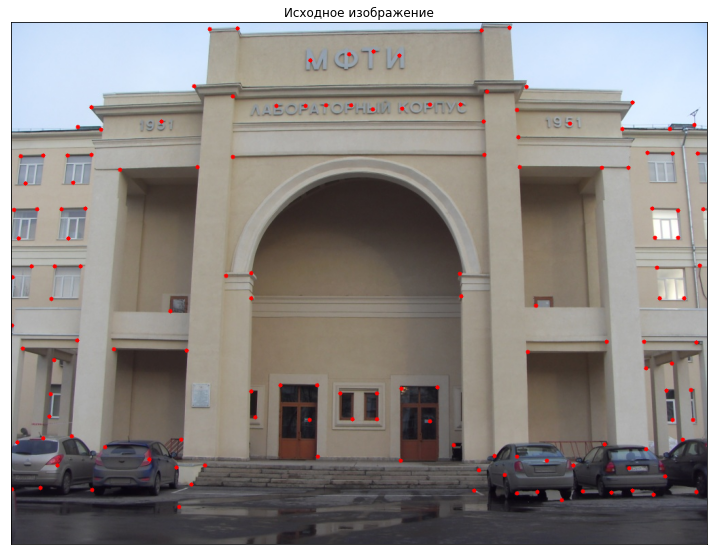

In [60]:
draw_image = image.copy()
# Отрисуем найденные точки
for i in corners:
    x, y = i.ravel()
    cv2.circle(draw_image, (x, y), 3, 255, -1)

plot_one_image(draw_image)

# Introduction to SIFT (Scale-Invariant Feature Transform)

В последних двух главах мы видели некоторые детекторы углов, такие как Харрис и т. Д. Они не зависят от вращения, что означает, что даже если изображение поворачивается, мы можем найти те же углы. Это очевидно, потому что углы остаются и в повернутом изображении. Но как насчет масштабирования? Угол может не быть углом, если изображение масштабировано. Например, проверьте простое изображение ниже. Угол на небольшом изображении в небольшом окне является плоским, когда он увеличен в том же окне. Так что угол Харриса не является масштабно-инвариантным.

<img src="https://i.ibb.co/N7kR8Lc/sift_scale_invariant.jpg" alt="Drawing" style="width: 400px;"/> 

Рассмотрим новый алгоритм Scale Invariant Feature Transform (SIFT), который позволяет сохранить инвариантость к масштабированию.

## Обнаружение экстремумов в пространстве

Из рисунка выше видно, что мы не можем использовать одно и то же окно для обнаружения ключевых точек с разным масштабом. Это нормально с небольшим углом. Но чтобы обнаружить большие углы, нам нужны большие окна. Для этого используется масштабная фильтрация. В нем найден лапласиан гауссовский для изображения с различными значениями $\sigma$. LoG действует как детектор капель, который обнаруживает капли разных размеров из-за изменения $\sigma$. Короче говоря, $\sigma$ действует как параметр масштабирования. Например, на изображении выше, ядро Гаусса с низким значением $\sigma$ дает высокое значение для небольшого угла, в то время как ядро гауссиана с высоким значением $\sigma$ хорошо подходит для большего угла. Таким образом, мы можем найти локальные максимумы по шкале и пространству, которые дают нам список значений $(x, y, \sigma)$, что означает, что существует потенциальная ключевая точка в точке $(x, y)$ в масштабе $\sigma$.

Но этот LoG немного дорог, поэтому алгоритм SIFT использует разность гауссианов, которая является приближением LoG. Разность по Гауссу получается как разница по размытию по Гауссу изображения с двумя разными $\sigma$, пусть это будут $\sigma$ и $k \sigma$. Этот процесс выполняется для разных октав изображения в гауссовой пирамиде. Это представлено на изображении ниже:

<img src="https://i.ibb.co/WWyXGrD/sift_dog.jpg" alt="Drawing" style="width: 400px;"/>

Как только эта DoG найдена, изображения ищут локальные экстремумы в масштабе и пространстве. Например, один пиксель в изображении сравнивается с его 8 соседями, а также с 9 пикселями в следующем масштабе и 9 пикселями в предыдущих масштабах. Если это локальный экстремум, это потенциальная ключевая точка. Это в основном означает, что ключевой момент лучше всего представлен в этом масштабе. Это показано на рисунке ниже:

<img src="https://i.ibb.co/2YN6FZ6/sift_local_extrema.jpg" alt="Drawing" style="width: 300px;"/>

Что касается различных параметров, в статье приведены некоторые эмпирические данные, которые можно суммировать как: число $octaves = 4$, количество уровней $scale = 5$, начальные $\sigma = 1.6$, $k = \sqrt {2}$ и т. Д. В качестве оптимальных значений.

## Локализация ключевых точек

Как только потенциальные ключевые точки найдены, их необходимо уточнить, чтобы получить более точные результаты. Они использовали расширение масштаба шкалы Тейлора, чтобы получить более точное местоположение экстремумов, и если интенсивность этих экстремумов меньше порогового значения (0,03 согласно статье), оно отклоняется. Этот порог называется контрастным порогом в OpenCV

У DoG более высокий отклик на ребра, поэтому ребра также должны быть удалены. Для этого используется концепция, похожая на угловой детектор Harris. Они использовали матрицу Гессиана 2x2 (H) для вычисления кривизны кривизны. Из углового детектора Харриса мы знаем, что для ребер одно собственное значение больше другого. Так что здесь они использовали простую функцию,

Если это отношение больше порога, называемого edgeThreshold в OpenCV, эта ключевая точка отбрасывается. Это дано как 10 в статье.

Таким образом, он устраняет любые малоконтрастные ключевые точки и граничные ключевые точки, а остающиеся точки - это сильные точки интереса.

## Ориентация значения

Теперь ориентация назначается каждой ключевой точке для достижения неизменности вращения изображения. Вокруг местоположения ключевой точки берется окрестность в зависимости от масштаба, и в этой области вычисляются величина и направление градиента. Создается гистограмма ориентации с 36 ячейками, охватывающими 360 градусов. (Он взвешивается по величине градиента и по гауссовому круглому окну с $\sigma$, равным 1,5-кратному масштабу ключевой точки. Принимается самый высокий пик в гистограмме, и любой пик выше 80% также считается для расчета ориентации. Он создает ключевые точки с одинаковым расположением и масштабом, но разными направлениями, что способствует стабильности сопоставления.

## Дескриптор ключевой точки

Теперь дескриптор ключевой точки создан. Окрестность 16x16 вокруг ключевой точки берется. Он разделен на 16 субблоков размером 4х4. Для каждого субблока создается гистограмма ориентации 8 бинов. Таким образом, доступно 128 значений бина. Он представлен в виде вектора для формирования дескриптора ключевой точки. В дополнение к этому, предприняты некоторые меры для достижения устойчивости к изменениям освещенности, вращению и т. Д.

## Сопоставление ключевых точек 

Ключевые точки между двумя изображениями сопоставляются путем определения ближайших соседей. Но в некоторых случаях второй ближайший матч может быть очень близко к первому. Это может произойти из-за шума или по другим причинам. В этом случае берется отношение ближайшего расстояния ко второму ближайшему расстоянию. Если оно больше 0,8, они отклоняются. Это устраняет около 90% ложных совпадений, в то время как отбрасывает только 5% правильных совпадений, согласно статье.

Так что это краткое изложение алгоритма SIFT. Для получения более подробной информации и понимания, чтение оригинальной статьи настоятельно рекомендуется.

In [61]:
# Step 1: Detect the keypoints using SURF Detector
detector = cv2.xfeatures2d.SIFT_create(nfeatures=500, nOctaveLayers=5, contrastThreshold=0.07, \
                                       edgeThreshold=10, sigma=1.3)

keypoints = detector.detect(image, None)

In [62]:
keypoints[0].class_id

-1

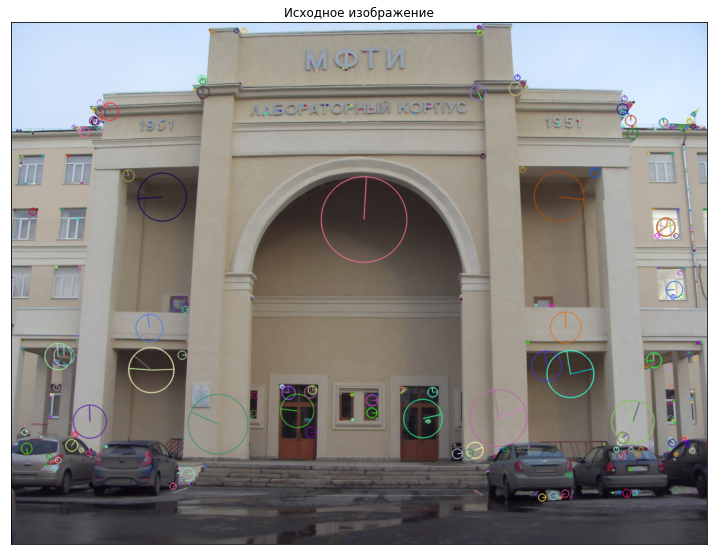

In [67]:
# Draw keypoints
draw_image = image.copy()
img_keypoints = np.empty((image.shape[0], image.shape[1], 3), dtype=np.uint8)
cv2.drawKeypoints(draw_image, keypoints, img_keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


# Show detected (drawn) keypoints
plot_one_image(img_keypoints)

##  Поиск объектов 

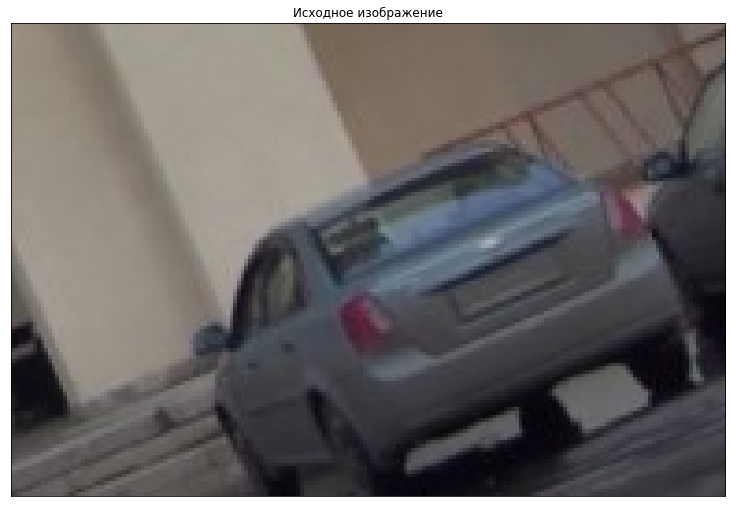

In [68]:
img_car = cv2.imread('img/crop_lk.jpg')
img_car = cv2.cvtColor(img_car, cv2.COLOR_BGR2RGB)

plot_one_image(img_car)

In [69]:
import skimage.exposure

In [70]:
img_car_new = skimage.exposure.adjust_gamma(img_car, gamma=1.7)

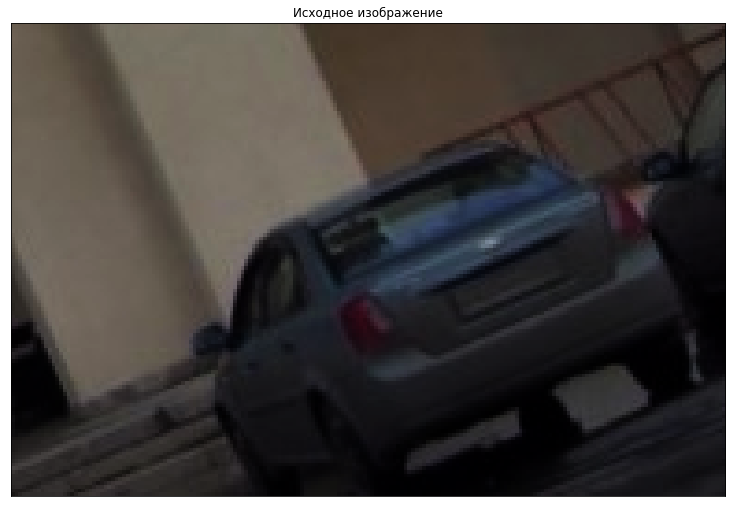

In [71]:
plot_one_image(img_car_new)

### Поиск особых точек и их дескрипторов

In [209]:
# Step 1: Detect the keypoints using SURF Detector
hyp_params = dict(
    nfeatures = 100,
    nOctaveLayers = 3,
    contrastThreshold = 0.03,
    edgeThreshold = 10,
    sigma = 1.6)  # hyp params

detector = cv2.xfeatures2d.SIFT_create(**hyp_params)

# detector = cv2.ORB_create()

In [215]:
image.shape, img_car.shape

((768, 1024, 3), (128, 193, 3))

In [212]:
# calculate feature points and they descriptors
%time keypoints1, desc1 = detector.detectAndCompute(image, None)
%time keypoints2, desc2 = detector.detectAndCompute(img_car, None)

CPU times: user 210 ms, sys: 9.44 ms, total: 219 ms
Wall time: 143 ms
CPU times: user 8.69 ms, sys: 1.23 ms, total: 9.92 ms
Wall time: 5.31 ms


In [213]:
desc2.shape

(100, 128)

### Сопоставление особых точек

Классические дескрипторы признаков (SIFT, SURF, ...) обычно сравниваются и сопоставляются с помощью евклидового расстояния (или L2-нормы). Поскольку дескрипторы SIFT и SURF представляют собой гистограмму ориентированного градиента (вейвлет-ответа Хаара для SURF) в окрестности, то альтернативами евклидового расстояния являются метрики, основанные на гистограммах ( χ2, Earth mover's distance (EMD), и тд).

Двоичные дескрипторы (ORB, BRISK, ...) сопоставляются с помощью расстояния Хэмминга. Это расстояние эквивалентно подсчету количества различных элементов для двоичных строк (подсчет населения после применения операции XOR): $D_{hamming}(a,b)=\sum_{i=0}^{n−1} a_i⊕b_i$

Для фильтрации совпадений Lowe предложил в использовать тест соотношения расстояний, чтобы попытаться устранить ложные совпадения. Вычисляется соотношение расстояний между двумя ближайшими совпадениями рассматриваемой ключевой точки, и это хорошее совпадение, когда это значение ниже порогового значения. 

Традиционно для сопоставления точек используют вариации алгоритма kNN. Мы же будем использовать модуль FLANN - это пакет заточенный на алгоритмы kNN.

Зададим параметры поиска:

1. Первый словарь - IndexParams. Для различных алгоритмов передаваемая информация объясняется в документации FLANN

2. Второй словарь - SearchParams. Он задает количество раз, когда деревья в индексе должны быть рекурсивно обработаны. Более высокие значения дают большую точность, но также требуют больше времени. 

Алшоритмы FLANN:
- FLANN_INDEX_LINEAR = 0
- FLANN_INDEX_KDTREE = 1
- FLANN_INDEX_KMEANS = 2
- FLANN_INDEX_COMPOSITE = 3
- FLANN_INDEX_KDTREE_SINGLE = 4
- FLANN_INDEX_HIERARCHICAL = 5
- FLANN_INDEX_LSH = 6
- FLANN_INDEX_SAVED = 254
- FLANN_INDEX_AUTOTUNED = 255

In [196]:
# init match algo
FLANN_INDEX_KDTREE = 2
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
# flann = cv2.BFMatcher()

In [214]:
# knn search
%time matches = flann.knnMatch(desc1, desc2, k=2)

CPU times: user 1.69 ms, sys: 791 µs, total: 2.48 ms
Wall time: 878 µs


In [198]:
len(matches)

500

In [199]:
# apply threshold rule
ratio_thresh = 0.7
good_matches = []
for m, n in matches:
    if m.distance < ratio_thresh * n.distance:
        good_matches.append(m)

In [200]:
len(good_matches)

3

In [201]:
good_matches

[<DMatch 0x7fc94959a310>, <DMatch 0x7fc9495965d0>, <DMatch 0x7fc94936d110>]

In [202]:
good_matches[0].queryIdx, good_matches[0].imgIdx

(31, 0)

In [203]:
x, y = keypoints1[good_matches[0].queryIdx].pt
x, y

(712.0, 639.0)

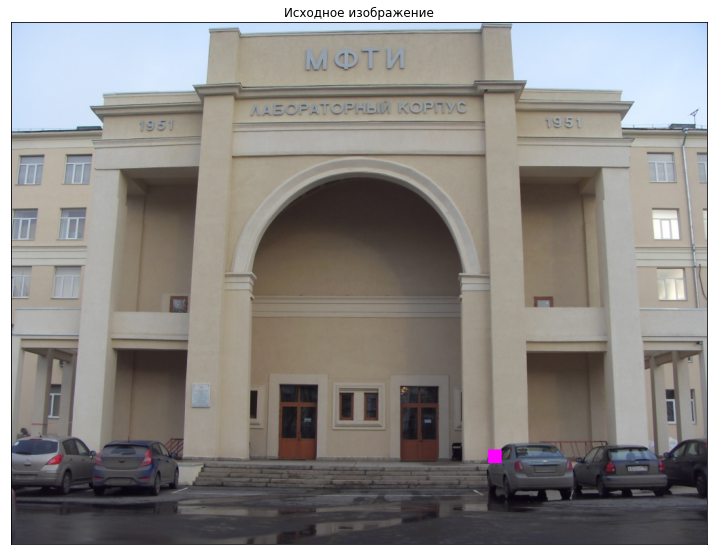

In [204]:
img_copy = image.copy()
img_copy[int(y)-10:int(y)+10, int(x)-10:int(x)+10, :] = [255, 0, 255]

plot_one_image(img_copy)

### Визауализация результатов поиска 

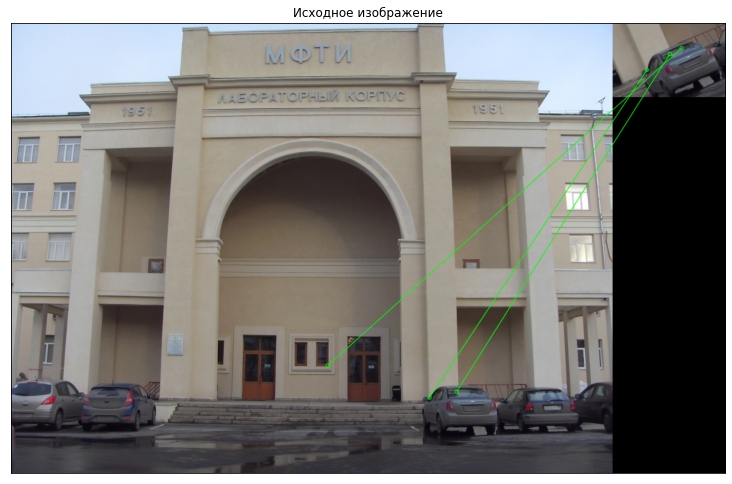

In [205]:
#-- Draw matches
img_matches = np.empty((max(image.shape[0], img_car.shape[0]), image.shape[1] + img_car.shape[1], 3), dtype=np.uint8)

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                  )

cv2.drawMatches(image, keypoints1, img_car, keypoints2, good_matches, img_matches, **draw_params)

#-- Show detected matches
plot_one_image(img_matches)